# The GLM with fMRI 
This tutorial will be all about how most univariate fMRI analyses are done: using the **GLM**. Specifically, we'll focus on the "estimation" part of the GLM (i.e., how do we estimate parameters?).

The GLM, or the General Linear Model, is a statistical model that underlies a range of statistical models that you're probably already familiar with: (M)ANOVA, *t*-test, *F*-test, and most importantly ordinary *linear regression*. Mathematically, all these different tests are specific instantiations of the GLM (check [this blog post](https://lindeloev.github.io/tests-as-linear/) if you want to know more about this equivalence).

Basically, the type of fMRI analysis you are going to learn in this course (often called 'univariate analysis' or 'Statistical Parametric Mapping') is just an linear regression model applied to time-series data. Given that you have some basic familiarity with these concepts, you will see during this tutorial that univariate fMRI analyses using the GLM are actually very straightforward. One important difference, when working with fMRI data, is that we need to take into account the shape of the BOLD response. Remember, the BOLD response is slow and typically peaks around 4-5 ms after stimulus onset following which it gradually decays. This can be incorporated into our predictor variable with the Heamodynamic Response Function (HRF) - a process termed *convolution*. Another important difference when working with GLM on fMRI data, is that we do not apply regression directly at the group level. Rather, we first estimate beta-parameters of each voxel given our predictor across the time-series of *each* individual (`first-level models`), and *then* we estimate the group-level effect of those first-level effects across *individuals* (`second-level models`). 


**What you'll learn**: after this tutorial ... 
* you know how to estimate and interpret parameters in a GLM and evaluate its model fit;
* you understand the importance of incorporating knowledge from the BOLD-response in the GLM;
 <br>
 
 **Time to complete:** 40 minutes 

## Recap: parameters of the GLM 

When doing fMRI, we are recording the signal at each voxel across a timeseries (the timecourse of the experiment). We are then interested in predicting this signal at each timepoint, given some predictor variable (this could for instance be the onset of stimulus events). For now, let's look at a simple example. Below we see two timeseries of 30 observations (datapoints); Y is our dependent variable (that we want to predict) and X is our independent variable (a.k.a. our predictor variable).

![XandY_timeseries](images/timeseries_XandY.png)

Now, let's plot the two variables as a function of each other. 

![XandY_scatter](images/XandY_scatter.png)

As you can see, there seems to be some positive linear relationship between $X$ (just the independent variable without the intercept) and $y$. In other words, an increase in $X$ will lead to an increase in $y$. But, at this moment, *how much exactly* $y$ changes for a increase in $X$ is unknown. By doing a linear regression with $X$ as our predictor of $y$, we can quantify this! 

The parameter that quantifies the influence of $X$ on $y$, calculated by this model is often called the **beta-parameter(s)** (but sometimes they're denoted as theta, or any other greek symbol/letter). The beta-parameter quantifies exactly how much $y$ changes if you increase $X$ by 1. Or, in other words, it quantifies how much influence $X$ has on $y$. In a formula ($\delta$ stands for "change in")\*: 

\begin{align}
\beta_{j} = \frac{\delta y}{\delta X_{j}} 
\end{align}

As you probably realize, each predictor in $X$ (i.e., $X_{j}$) has a parameter ($\beta_{j}$) that quantifies how much influence that predictor has on our target variable ($y$). This includes the intercept, our vector of ones (which is in textbooks often denoted by $\beta_{0}$; they often don't write out $\beta_{0}X_{0}$ because, if a vector of ones is used, $\beta_{0}\cdot 1$ simplifies to $\beta_{0}$).

Thus, linear regression describes a model in which a set of beta-parameters are calculated to characterize the influence of each predictor in $X$ on $y$, that together explain $y$ as well as possible (but the model is usually not perfect, so there will be some *error*, or "unexplained variance", denoted by $\epsilon$). As such, we can formulate the linear regression model as follows:

\begin{align}
y = \beta_{0} + X_{1}\beta_{1} + X_{2}\beta_{2} ... + X_{P}\beta_{P} + \epsilon
\end{align}

which is often written out as (and is equivalent to the formula above):

\begin{align}
y = \sum_{j=1}^{P}X_{j}\beta_{j} + \epsilon
\end{align}

Here, $\epsilon$ is the variance of $y$ that cannot be explained by our predictors (i.e, the *error*). 

But how does linear regression estimate the beta-parameters? The method most often used is called **'ordinary least squares'** (OLS; or just 'least squares'). This method tries to find a "weight(s)" for the independent variable(s) such that when you multiply the weight(s) with the independent variable(s), it produces an estimate of $y$ (often denoted as $\hat{y}$, or "y-hat") that is as 'close' to the true $y$ as possible. In other words, least squares tries to 'choose' the beta-parameter(s) ($\hat{\beta}$) such that the difference between $X$ multiplied with the beta(s) (i.e. our best guess of $y$, denoted as $\hat{y}$) and the true $y$ is minimized\*. 

Let's just formalize this formula for the 'best estimate of $y$' (i.e. $\hat{y}$):

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

![XandY_modelFit](images/XandY_modelFit.png)

OBS! Remember, that in linear regression we always model the *intercept* in addition to the predictor(s). The intercept is the expected value of *Y* when *X*=0. This parameter has a beta-weight as well (as the predictors), which is also be estimed by OLS. Thus, OLS tries to find the weights of both the *intercept* and each of our *predictor* variables, that will minimize the error (i.e. the differnece between y and \hat{y}). 

## Modeling the BOLD repsonse 
### Single-subject single-voxel example 

Univariate fMRI analyses basically use the same linear regression model as we've explained above to model the activation of voxels (with some minor additions) based on some design-matrix. The design matrix contains one column for each of our predictors (+ the intercept) with one row per measurement. 

### The target
However, compared to "regular" data, one major difference is that *the dependent variable ($y$) in fMRI analyses is timeseries data*, which means that the observations of the dependent variable (activation of voxels) vary across time. 

How does such a time-series data look like? Let's look at a (simulated) time-series from a single voxel:

In [ ]:
import os
import pip
# os.system('python -m pip install numpy')
# os.system('python -m pip install matplotlib')
# os.system('python -m pip install scipy')
# os.system('python -m pip install nilearn')

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline

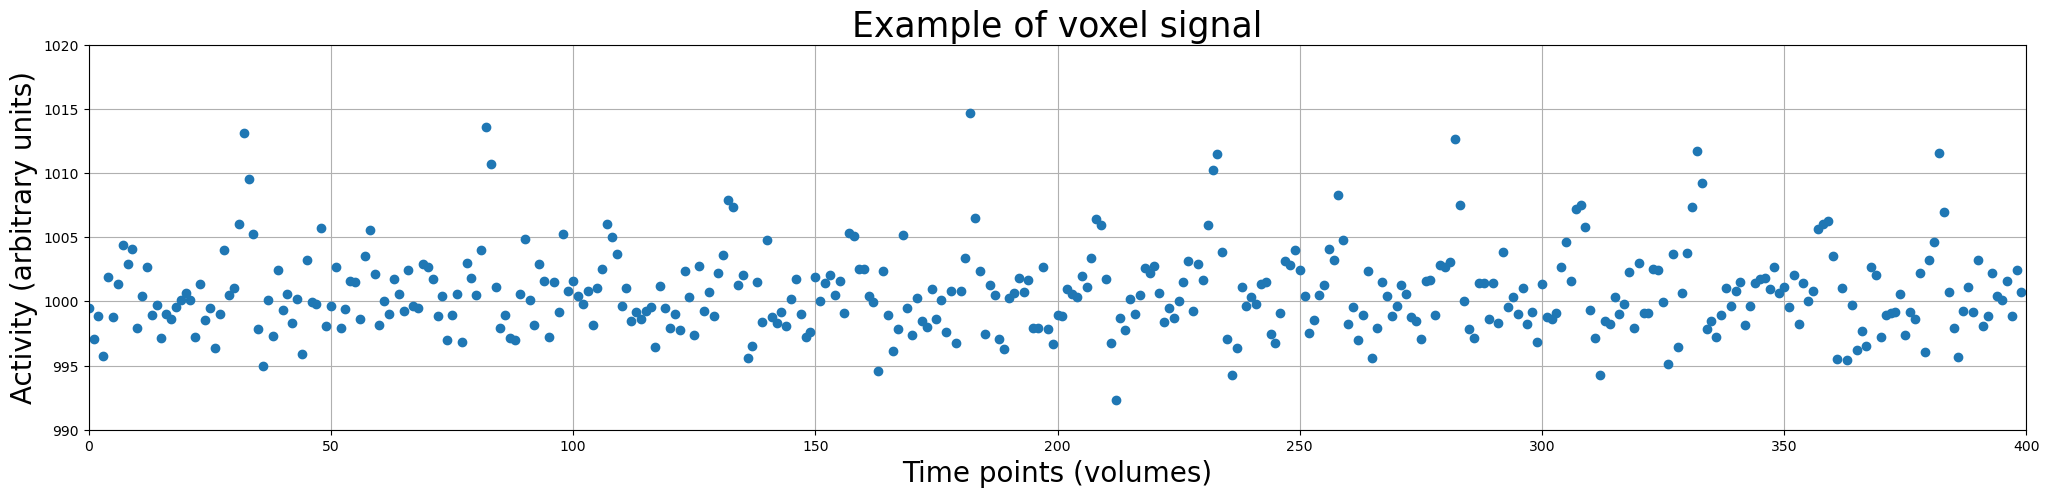

In [2]:
voxel_signal = np.load('data/example_voxel_signal.npy')
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal, 'o')
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (990, 1020)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

So, the voxel timeseries (i.e. activation over time; often called 'signal') is our dependent variable ($y$). Thus, the different time points (with corresponding activity values) make up our observations/samples!

<div class='alert alert-info'>
<b>ToThink1</b> : Suppose that the TR ("time to repetition", i.e. how long it takes to measure each volume) of our acquisition was 2 seconds, can you deduce the duration of the experiment (in seconds) from the plot above?

Hint: You can also use voxel_signal.shape
    
(Solution at the end)
</div>

WRITE YOUR ANSWER TO ToThink1 HERE:

So, in the plot above, the data points represent the activity (in arbitrary units) of a single voxel across time (measured in volumes). This visualization of the time-series data as discrete measurements is not really intuitive. Usually, we plot the data as continuous line over time (but always remember: fMRI data is a discretely sampled signal -- *not* a continuous one). Let's plot it as a line:

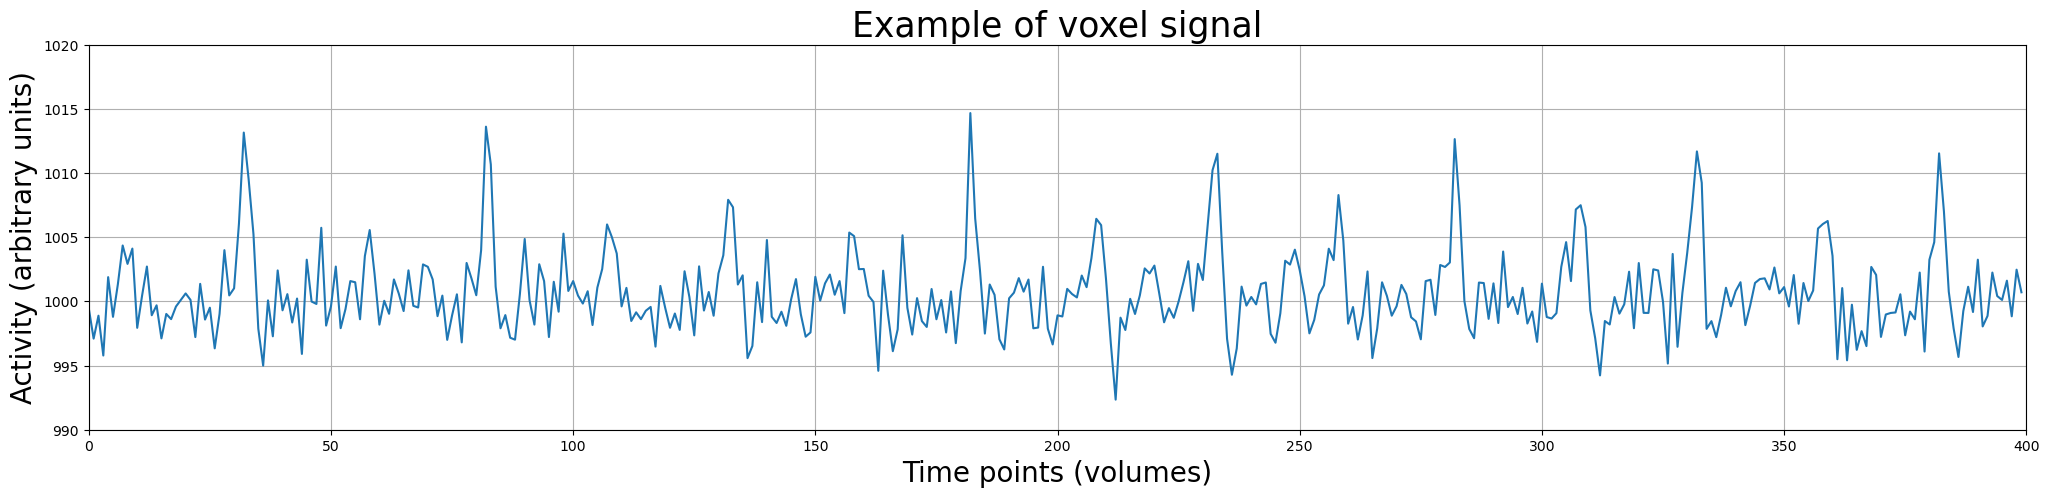

In [3]:
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

Alright, this looks better. Now, let's look at our potential predictors ($X$).

### The predictors, or: what should we use to model our target?

#### Defining independent variables
So, we know what our target is (the time-series data), but what do we use to model/explain our signal? Well, in most neuroimaging research, your predictors are defined by your experimental design! In other words, your predictors consist of *whatever you think influenced your signal*.

This probably sounds nonsensical, which is likely caused by the fact that we derive our independent variables (predictors) in most (observational) psychological research differently. This is because in (observational) psychological studies *both the independent variables and the dependent variables are __measured__*. In other words, our predictors are just other variables that you measured in your study. 

In neuroimaging research, however, we often derive our predictors not from measures variables but from properties of the particular experiment that we use in the MRI-scanner (or during EEG/MEG acquisiton, for that matter). In other words, we can use any property of the experiment that we believe explains our signal.

Alright, probably still sounds vague. Let's imagine a (hypothetical) experiment in which we show subjects images of either circles or squares during fMRI acquisition lasting 800 seconds, as depicted in the image below:

![img](https://docs.google.com/drawings/d/e/2PACX-1vQwC4chpnzsDEzKhrKH_WHhMX7vJswY4H0pkyIxdlxI_I2GG5e8i6lsiWUO0SUk7NBgdV-vXD5PIleJ/pub?w=950&h=397)

Note that the interstimulus interval (ISI, i.e., the time between consecutive stimuli) of 50 seconds, here, is quite unrealistic; often, fMRI experiments have a much shorter ISI (e.g., around 6 seconds). Here, we will use an hypothetical experiment with an ISI of 50 seconds because that simplifies things a bit and will make figures easier to interpret.

Anyway, let's talk about what predictors we could use given our experimental paradigm. One straighforward suggestion about properties that influence our signal is that our signal is influenced by the stimuli we show the participant during the experiment. As such, we could construct a predictor that predicts some response in the signal when a stimulus (here: a square or a circle) is present, and no response when a stimulus is absent.

Fortunately, we kept track of the onsets (in seconds!) of our stimuli during the experiment:

In [4]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)

In other words, the first circle-stimulus was presented at 60 seconds after the scan started and the last square-stimulus was presented 710 seconds after the can started.

For now, we'll ignore the difference between square-stimuli and circle-stimuli by creating a predictor that lumps the onsets of these two types of stimuli together in one array. This predictor thus reflects the hypothesis that the signal is affected by the presence of a stimulus (regardless of whether this was a square or a circle). (Later in the tutorial, we'll explain how to *compare* the effects of different conditions.)

We'll call this predictor simply `onsets_all`:

In [5]:
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


Now, we need to do one last thing: convert the `onsets_all` vector into a proper predictor. Right now, the variable contains only the onsets, but a predictor should be an array with the same shape as the target.

Given that our predictor should represent the hypothesis that the signal responds to the presence of a stimulus (and doesn't respond when a stimulus is absent), we can construct our predictor as a vector of all zeros, except at indices corresponding to the onsets of our stimuli, where the value is 1.

We do this below:

In [6]:
predictor_all = np.zeros(800)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (800,)

Contents of our predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 

We can even plot it in a similar way as we did with the voxel signal:

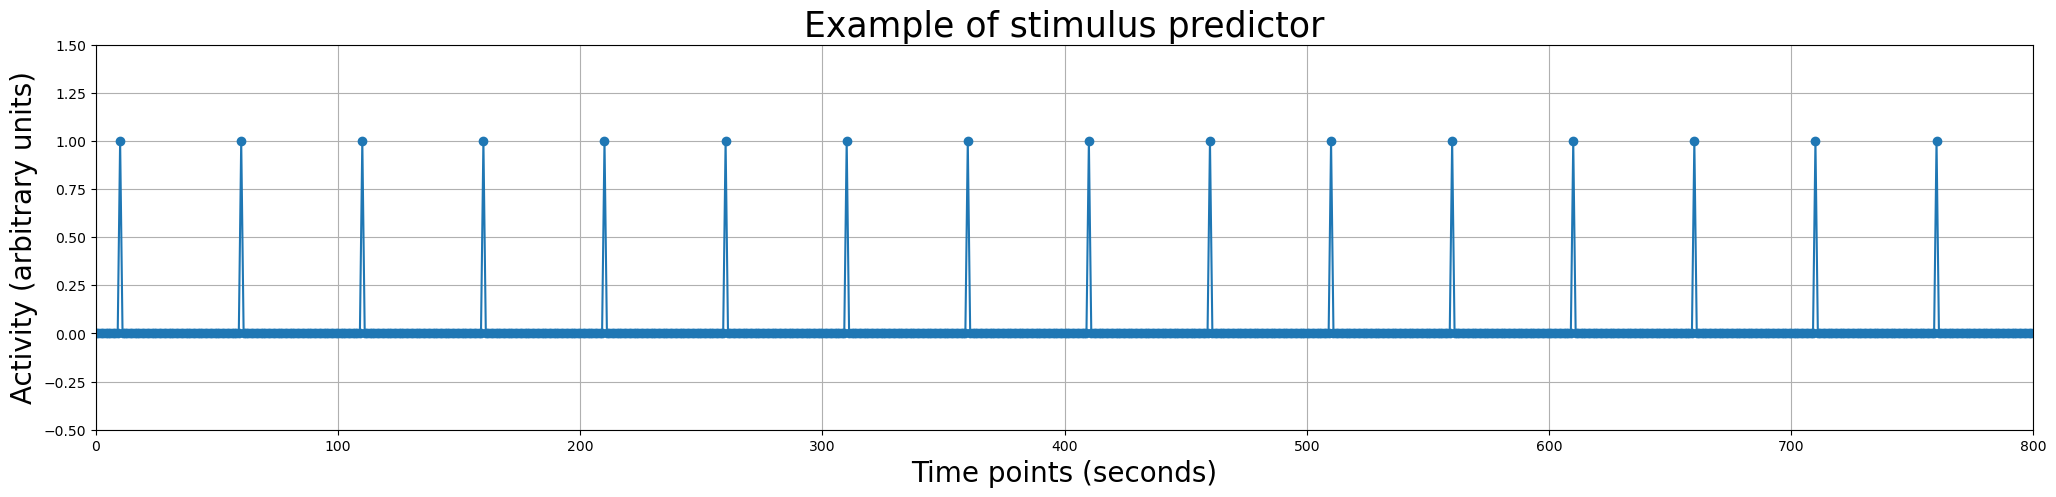

In [7]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 800)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

#### Resampling
However, if you look back at the plot of the voxel signal, you might notice that there is a problem in our stimulus-predictor - it seems to be on a different timescale than the signal. And that's true! The signal from the voxel is measured in volumes (in total 400, with a TR of 2 seconds) while the stimulus-onsets are defined in seconds (ranging from 10 to 760)!

This "issue" can be solved by downsampling our predictor to the time resolution of our signal, i.e., one datapoint every two seconds (given that our TR is 2 seconds). In the plot below, we show you with dashed red lines which datapoints would constitute our predictor *after* downsampling (we only show the first 100 seconds for clarity).

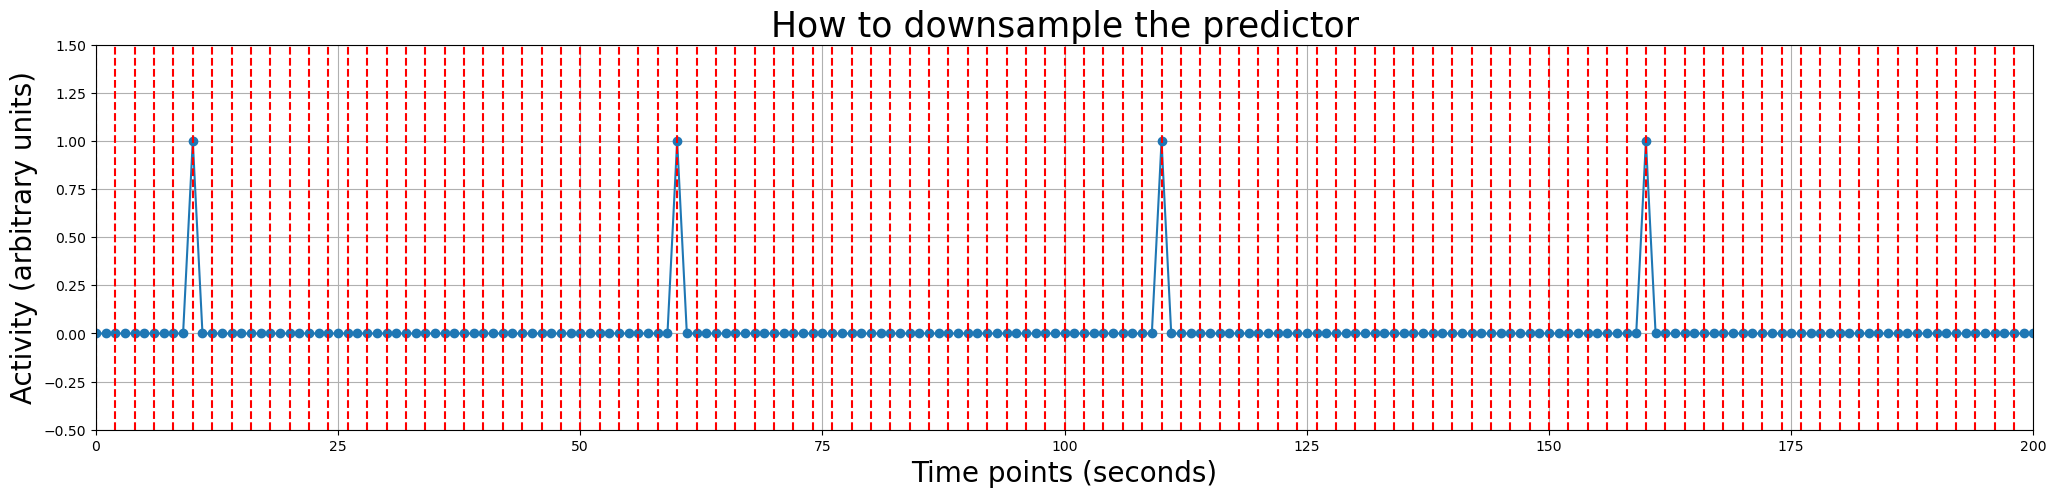

In [8]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

Resampling in Python can be done using the `interp1d` function from the `scipy.interpolate` package. It works by first creating a mapping between the *scale* of the original array and the *values* of the original array, and then converting the original array to a *different scale*. Don't worry about understanding all the details of this function for now (this step is automatically computed by most pre-processing pipelines), just make sure you understand why we do it. 

Alright, let's try this on our predictor by resampling it from the original scale (0-800 seconds) to the scale of our signal (i.e., at 0, 2, 4, 8 ... 800 seconds, assuming a TR of 2 seconds). Note the function `np.arange`, which can be used to create evenly spaced arrays (with `np.arange(start, stop, step)`):

In [9]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-800, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 800, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 800, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 800 datapoints (0-800, in seconds)
Desired scale has 400 datapoints (0, 2, 4, ... 800, in volumes)
Downsampled predictor has 400 datapoints (in volumes)


Awesome! Now, we have a predictor ($X$) and a target ($y$) of the same shape (i.e., 400 timepoints), so we can apply linear regression! But before we do this, let's plot the predictor and the signal in the same plot:

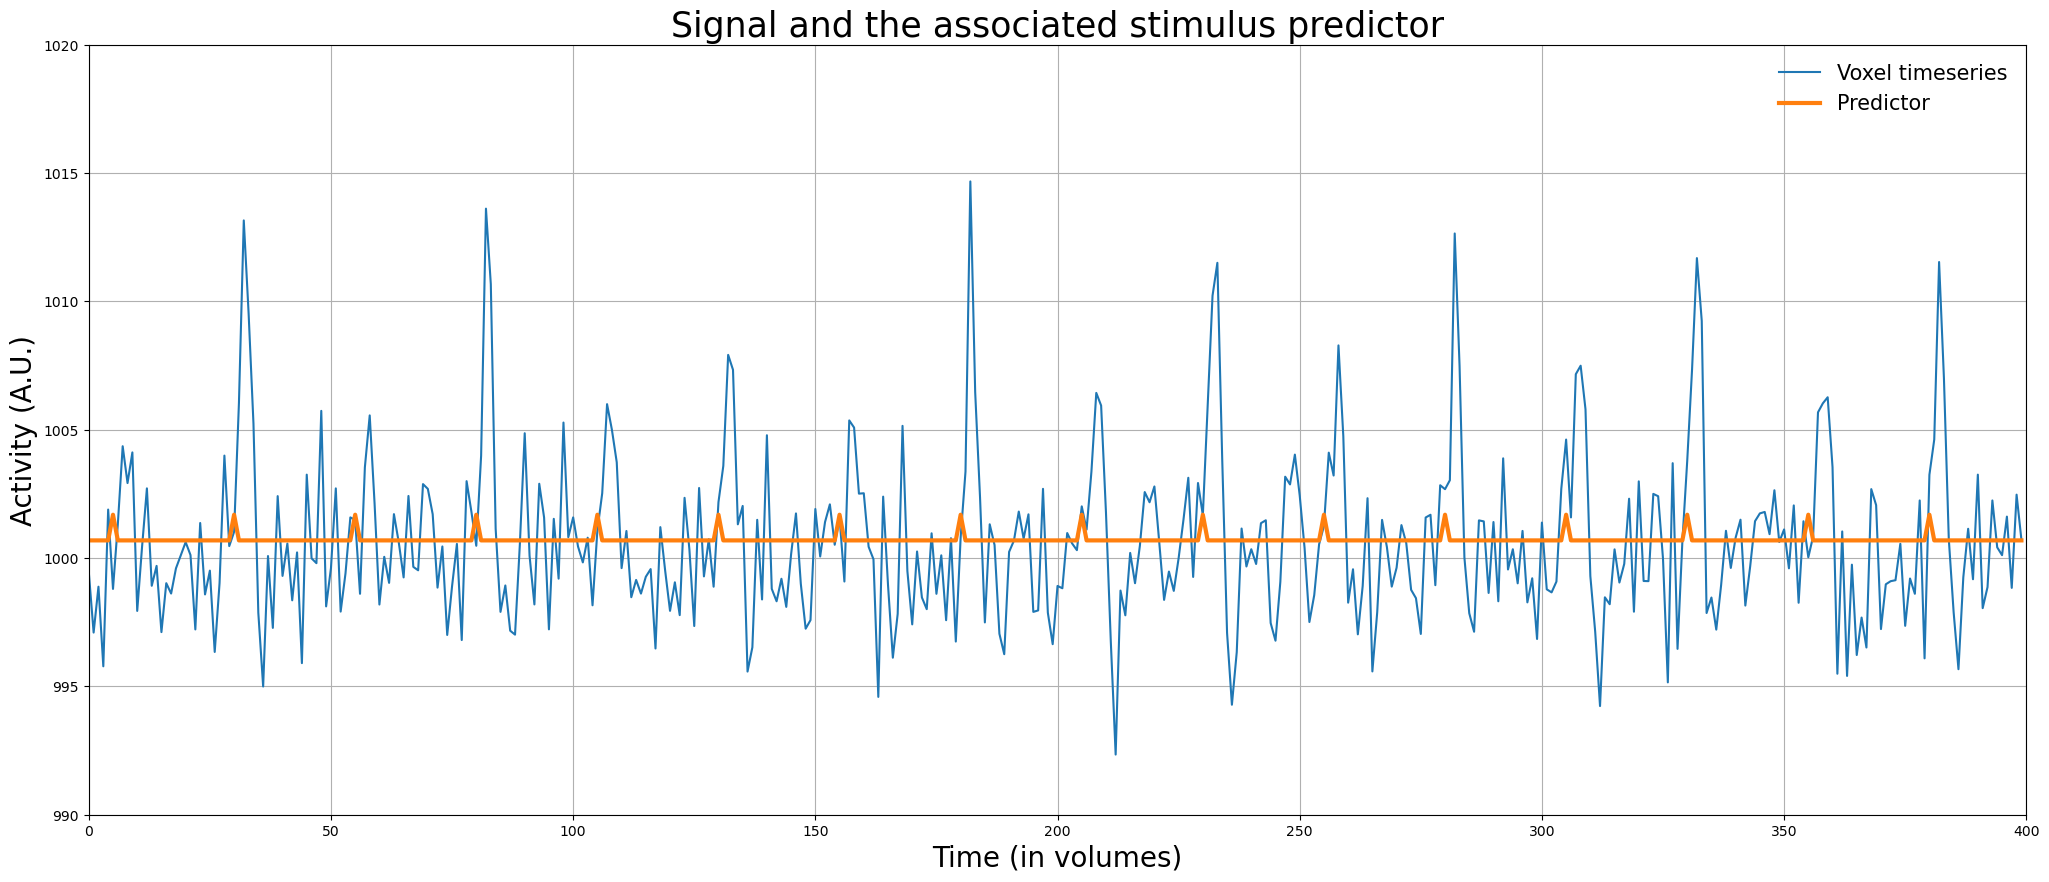

In [10]:
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds + voxel_signal.mean(), lw=3)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

Often, the design matrix is actually specified with higher precision (e.g., on the scale of milliseconds) than we did in the previous example (i.e., seconds) to accomodate onsets that are not "locked" to full seconds (e.g., $t=10$, $t=60$, but never $t=10.296$). We'll come back to this issue later in the tutorial.

At this moment, we have everything that we need to run linear regression: a predictor (independent variable) and a signal (target/dependent variable) at the same scale and the same number of data points! This regression analysis allows us to answer the question whether the activity of the signal is significantly different when a stimulus is presented (i.e., at times when the predictor contains ones) than when no stimulus is presented (i.e., at times when the predictor contains zeros). 

Or, phrased differently (but mathematically equivalent): what is the effect of a unit increase in the predictor ($X = 0 = \mathrm{no\ stimulus} \rightarrow X = 1 = \mathrm{stimulus}$) on the target (the signal)? We will answer this question in the next section!

### Regression on fMRI data & interpretation parameters
As said before, applying regression analysis on fMRI data is done largely the same as on regular non-timeseries data. In the next, we're going to do exactly that.

We'll start by adding an intercept to <tt>predictor_all_ds</tt>, creating a new variable called <tt>X_simple</tt>. <tt>X_simple</tt> is our `design matrix`. Then, we will run linear regression on the <tt>voxel_signal</tt> data and save the beta-parameters in a new variable named <tt>betas_simple</tt>. 

<AxesSubplot: label='conditions', ylabel='scan number'>

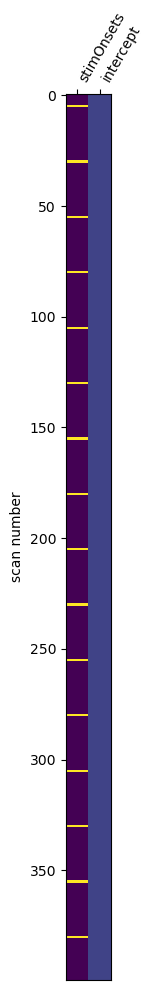

In [11]:
from nilearn import plotting 
import pandas as pd

#Create design matrix (our predictor variable + intercept variable) - as pandas dataframe 
intercept = np.ones(len(predictor_all_ds))

X_simple = pd.DataFrame({
    'stimOnsets': predictor_all_ds, 
    'intercept': intercept}
)

#Plot the design matrix 
plotting.plot_design_matrix(X_simple)

Cool. Our design matrix now has one column for our predictor variable with 0 on the timepoints with no stimulus and 1 on the timepoints with stimulus onset. Additionally, the design matrix has a *constant* to model the intercept. 

Alright then. Let's solve the model and estiamte our beta-parameters. We will use the `sklearn`package for this in python. 

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

#Define and fit the model 
model = LinearRegression()
model.fit(X_simple, voxel_signal)

#Inspect model fit (R^2 = explained varaince)
r_sq = model.score(X_simple, voxel_signal)
print(f"Explained variance: {r_sq}")

#Inspect estimated beta-parameters 
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

#Get predicted voxel signal given the estimated beta-parameters 
y_pred = model.predict(X_simple)

Explained variance: 0.0038767539784901883
Intercept: 1000.6470168433175
Slope: 1.02307436548785


This gives us the following beta-parameters: 1000.647 for the intercept and 1.023 for our stimulus-predictor. This means that our linear regression model for that voxel is as follows:

\begin{align}
y_{voxel} = \beta_{intercept} + X_{stim}\beta_{stim} + \epsilon = 1000.647 + X_{stim}1.023 + \epsilon
\end{align}

This simply means that for a unit increase in $X$ (i.e., $X = 0 \rightarrow X = 1$), $y$ increases with 1.023. In other words, on average the signal is 1.023 higher when a stimulus is present compared to when a stimulus is absent!

To aid interpretation, let's plot the signal ($y$) and the predicted signal ($\hat{y} = \beta X$) in the same plot.

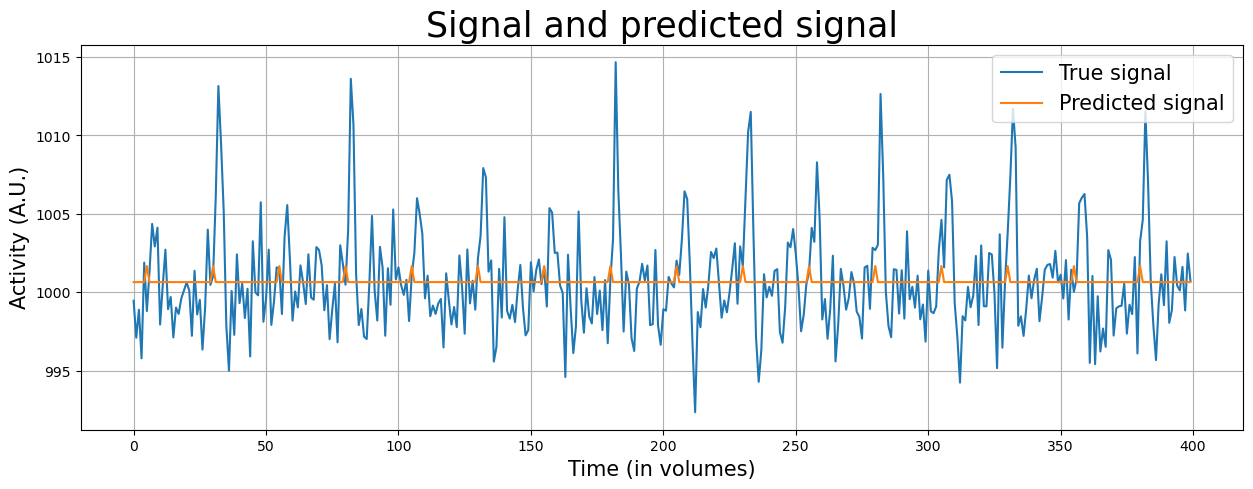

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(voxel_signal)
plt.plot(y_pred)
plt.xlabel('Time (in volumes)', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.legend(['True signal', 'Predicted signal'], loc='upper right', fontsize=15)
plt.title("Signal and predicted signal", fontsize=25)
plt.grid()
plt.show()

The orange line represents the predicted signal, which is based on the original predictor ($X$) multiplied (or "scaled") by the associated beta-parameters ($\beta$). Graphically, you can interpret the beta-parameter of the stimulus-predictor ($\beta_{stim}$) as the maximum height of the peaks in the orange line\* and the beta-parameter of the intercept ($\beta_{intercept}$) as the difference from the flat portion of the orange line and 0 (i.e. the "offset" of the signal).

---
\* This holds true only when the maximum value of the original predictor is 1 (which is true in our case)

Let's zoom in on a portion of the data to show this: 

here is  (0, 400)


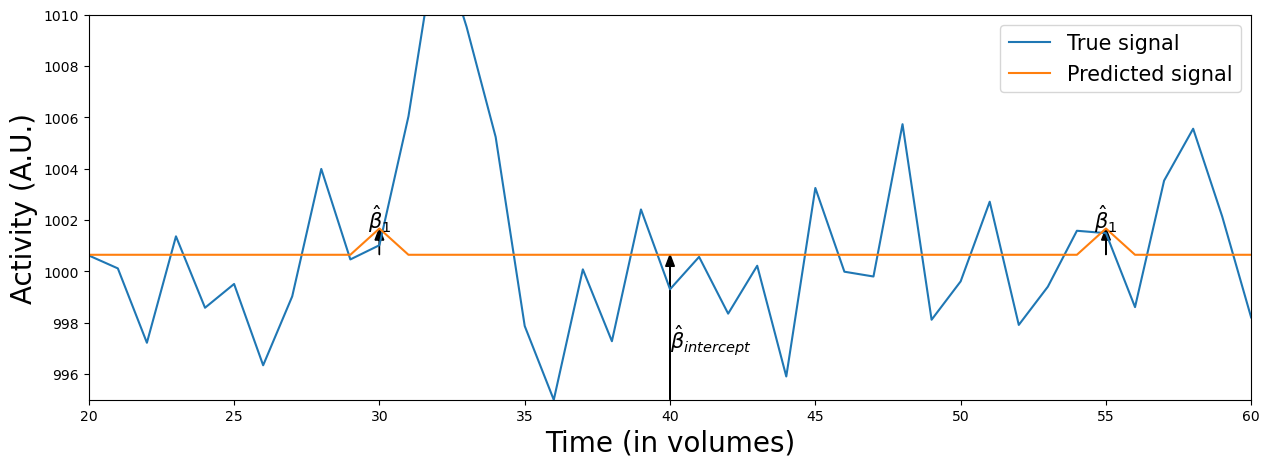

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(voxel_signal)
plt.plot(y_pred)
plt.xlim(20, 60)
plt.ylim(995, 1010)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)

print('here is ', x_lim)
x_lim = (20,60)
y_lim = (995,1010)
xmid = (x_lim[1] + x_lim[0]) // 2
plt.text(xmid, y_lim[0] + (model.intercept_ - y_lim[0]) // 2, r"$\hat{\beta}_{intercept}$", fontsize=15)
plt.arrow(xmid, y_lim[0], 0, model.intercept_ - y_lim[0], head_width=0.3,
            length_includes_head=True, color='k')

for t in np.where(y_pred[x_lim[0]:x_lim[1]] == y_pred.max())[0]:
    t += x_lim[0]
    plt.arrow(t, model.intercept_, 0, model.coef_[0], head_width=0.3,
                length_includes_head=True, color='k')
    plt.text(t, model.intercept_ + model.coef_[0], r"$\hat{\beta}_{1}$", fontsize=15, ha='center')
    
plt.legend(['True signal', 'Predicted signal'], fontsize=15, loc='upper right')
plt.show()

Anyway, there seems to be an effect on voxel activity when we show a stimulus &mdash; an increase of 1.023 in the signal on average (about 0.1% percent signal change) &mdash; but you've also seen that the model fit is quite bad ($R^2 = 0.004$, about 0.4% explained variance) ...

What is happening here? Is our voxel just super noisy? Or is something wrong with our model? We'll talk about this in the next section!

### Using the BOLD response in GLM models
Let's go back to our original idea behind the predictor we created. We assumed that in order to model activity in response to our stimuli, our predictor should capture an increase/decrease in activity *at the moment of stimulus onset*. But this is, given our knowledge of the BOLD-response, kind of unrealistic to assume: it is impossible to measure instantaneous changes in neural activity in response to stimuli or tasks with fMRI, *because the BOLD-response is quite slow and usually peaks around 5-7 seconds **after** the 'true' neuronal activity (i.e. at cellular level)*. 

<img src="https://mriquestions.com/uploads/3/4/5/7/34572113/7115861_orig.png" alt="img" width="500"/>

In our model above, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as an instantaneous response to a stimulus event. 

You can imagine that if you incorporate our knowledge about the shape of the BOLD-response into our model, the fit will likely get better! In this section, we'll investigate different ways to incorporate knowledge of the BOLD-response in our predictors.

#### The canonical HRF
The easiest and most often-used approach to incorporating knowledge about the BOLD-response in univariate analyses of fMRI data is to assume that each voxel responds to a stimulus in a fixed way. In other words, that voxels always respond (activate/deactivate) to a stimulus in the same manner. This is known as using a "canonical haemodynamic response function (HRF)". Basically, an HRF is a formalization of how we think the voxel is going to respond to a stimulus. A *canonical* HRF is the implementation of an HRF in which you use the same HRF for each voxel, participant, and condition. There are other implementations of HRFs (apart from the canonical), in which you can adjust the exact shape of the HRF based on the data you have; examples of these HRFs are *temporal basis sets* and *finite impulse reponse models* (FIR), which we will not discuss in this course. 

There are different types of (canonical) HRFs; each models the assumed shape of the BOLD-response slightly differently. For this course, we'll use the most often used canonical HRF: the double-gamma HRF, which is a combination of two different gamma functions (one modelling the overshoot and one modelling the post-stimulus undershoot).

We'll use the "double gamma" HRF implementation of the [nilearn](https://nilearn.github.io) Python package. They provide different "versions" of the HRF (which differ slightly in their shape); we'll use the "Glover" version, which is based on a double-[gamma function](https://en.wikipedia.org/wiki/Gamma_function): `glover_hrf`.

In [16]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

This function takes a couple of arguments (the most important being: TR, oversampling factor, and length of the HRF in seconds), and returns a double gamma HRF. It is important to make sure that your HRF is on the same timescale as our design (predictors). In the previous section, we made sure we defined our predictor at the time scale of seconds first before downsampling it to a time resolution of 2 seconds (i.e., the TR). 

Thus, given a TR of 2, we can use a "oversampling factor" of 2 to get the HRF on the timescale of seconds:

In [20]:
TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


As you can see, the length of the `canonical_hrf` variable is 32 (seconds). Now, let's plot it:

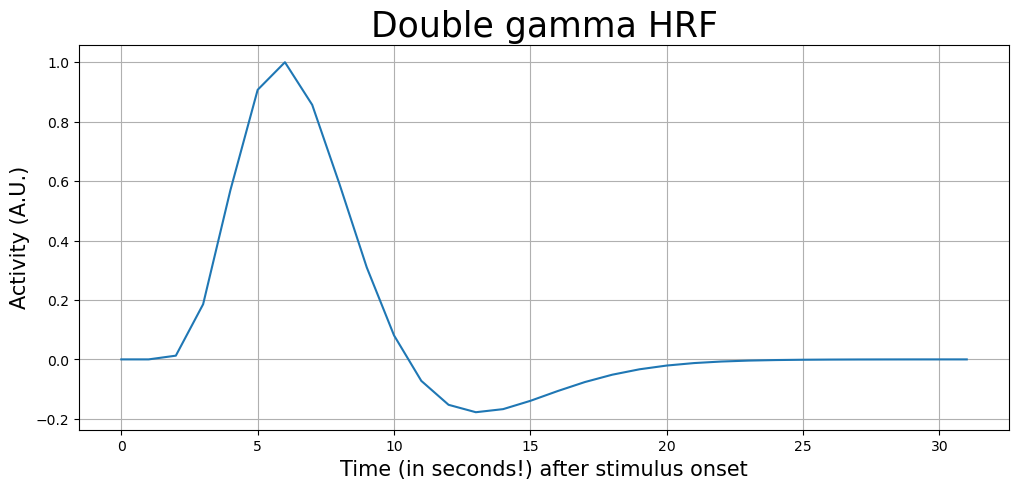

In [21]:
t = np.arange(0, canonical_hrf.size)

plt.figure(figsize=(12, 5))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

#### Convolution
The figure of the HRF shows how we'd expect that an idealized (noiseless) response to a single event would look like. But how should we incorporate this HRF into our model? Traditionally, this is done using a mathematical operation called **convolution**. Basically, it "slides" the HRF across our 0-1 coded stimulus-vector from left to right and elementwise multiplies the HRF with the stimulus-vector. This is often denoted as:

\begin{align}
X_{\mathrm{conv}} = \mathrm{HRF} * X_{\mathrm{original}}
\end{align}

in which $*$ is the symbol for convolution, $X_{\mathrm{original}}$ is the original stimulus-vector, and $X_{\mathrm{conv}}$ the result of the convolution.

Let's plot an example to make it clearer. Suppose we have an onset-vector of length 100 (i.e., the experiment was 100 seconds long) with three stimulus presentations: at $t = 10$, $t = 40$, and $t = 70$. The stimulus-vector (upper plot), double-gamma HRF (right plot), and the result of the convolution of the stimulus-vector and the HRF (lower plot) looks as follows:

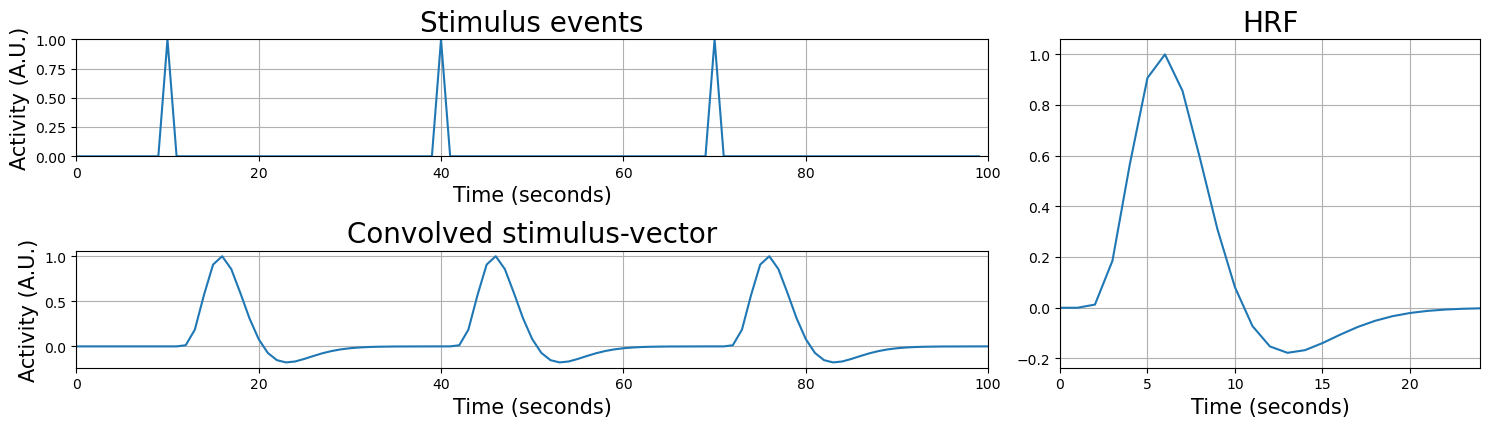

In [22]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

#We will use the numpy function np.convolve() to convolve the stim vector with the HRF
convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')

#We will plot all three variables in a grid.

#First, the stimulus vector
plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

#Second, the hemodynamic response function
plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

#Lastly, the combination
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

The result &mdash; the convolved stimulus-vector &mdash; is basically the output of a the multiplication of the HRF and the stimulus-events when you would "slide" the HRF across the stimulus vector. As you can see, the convolved stimulus-vector correctly shows the to-be-expected lag and shape of the BOLD-response! Given that this new predictor incorporates this knowledge of the to-be expected response, it will probably model the activity of our voxel way better. Note that the temporal resolution of your convolved regressor is necessary limited by the resolution of your data (i.e. the TR of your fMRI acquisition). That's why the convolved regressor doesn't look as "smooth" as the HRF. 

As you can see in the code for the plot above, numpy provides us with a function to convolve two arrays:

```python
np.convolve(array_1, array_2)
```

Now, we can convolve the HRF with out stimulus-predictor. Importantly, we want to do this convolution operation in the resolution of our onsets (here: seconds), not in the resolution of our signal (TR) (the reason for this is explained clearly in Jeanette Mumford's [video on the HRF](https://www.youtube.com/watch?v=5JNX34gYG7Q).)
Therefore, we need to perform the convolution on the variable `predictor_all` (*not* the downsampled variable: `predictor_all_ds`)!

We'll do this below (we'll reuse the `canonical_hrf` variable defined earlier):

In [23]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (831,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


It's a bit of a hassle (squeezing out the singleton axis, trimming, adding the axis back ...), but now we have a predictor which includes information about the expected HRF!

Let's look at the predictor before and after convolution in the same plot:

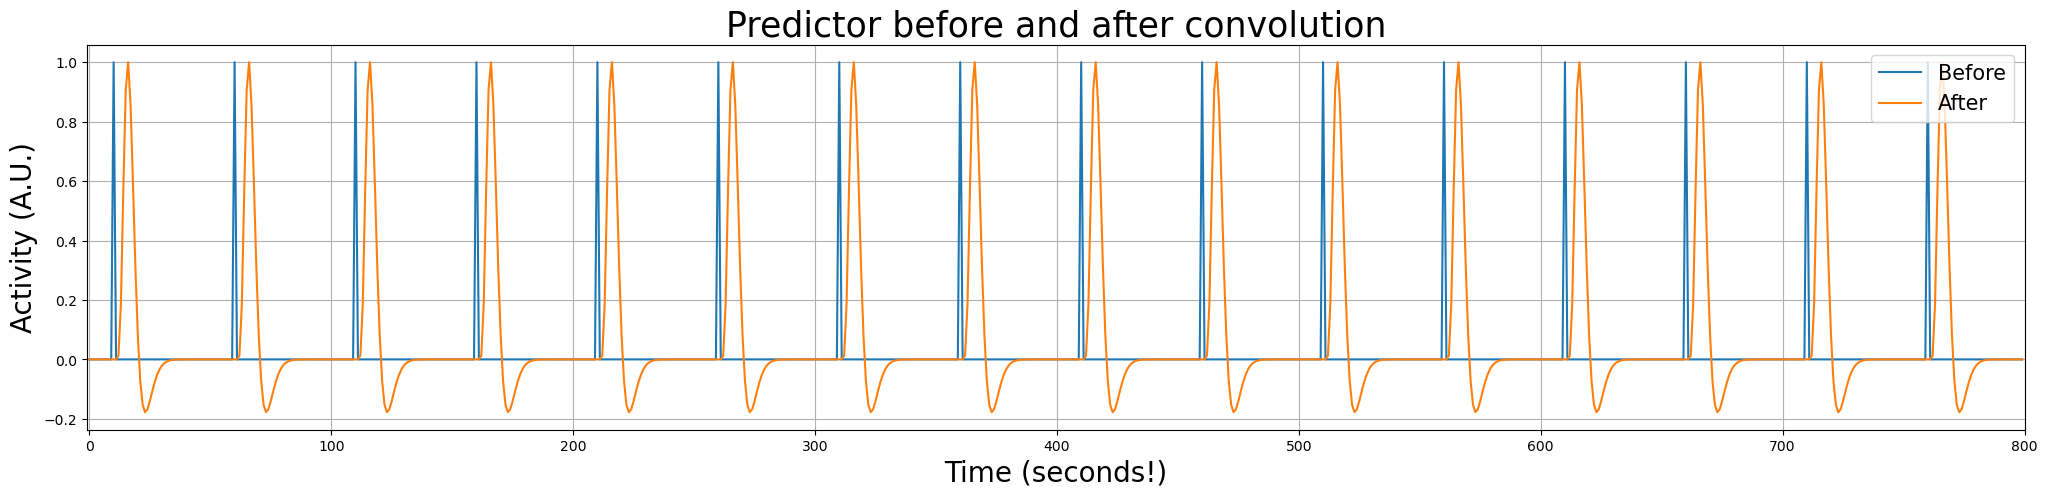

In [24]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

#### Linear scaling
Great! Our predictor now includes the expected 'lag' and shape of the HRF, and we can start analyzing our signal with our new convolved predictor! But before we'll do this, there is one more concept that we'll demonstrate. This is the concept of **linear scaling** of the BOLD-response. This assumes that the BOLD-response will linearly scale with the input it is given.

Let's see how that works:

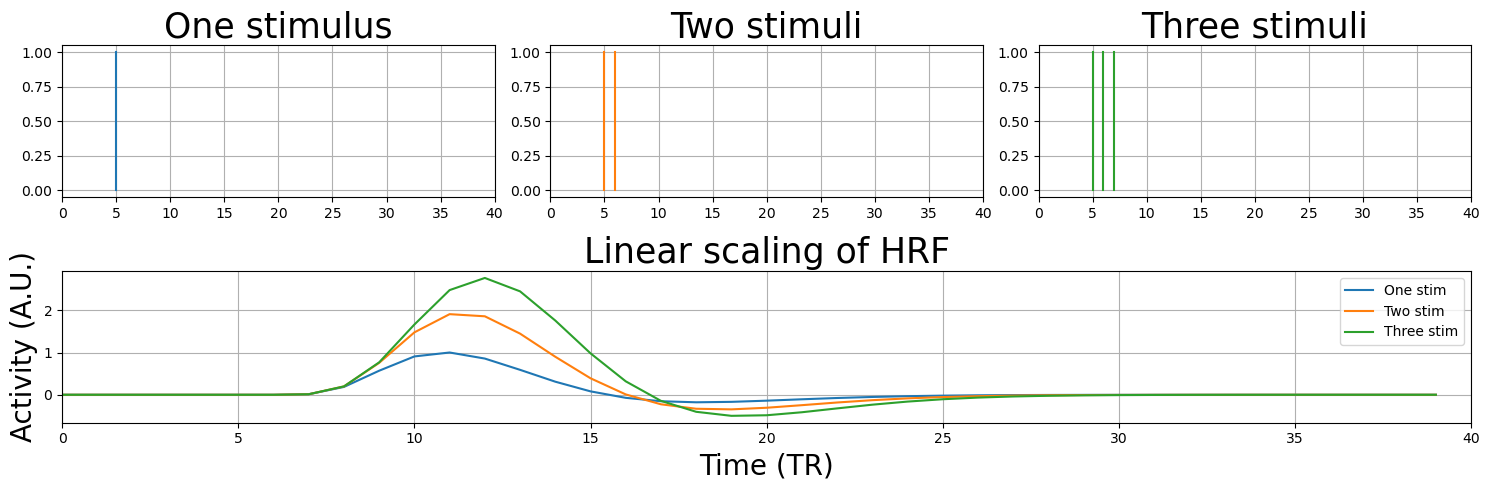

In [25]:
plt.figure(figsize=(15, 5))

N = 40
one_stim = np.zeros(N)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, canonical_hrf)[:N]
two_stim = np.zeros(N)
two_stim[[5, 6]] = 1
two_stim_conv = np.convolve(two_stim, canonical_hrf)[:N]
three_stim = np.zeros(N)
three_stim[[5, 6, 7]] = 1
three_stim_conv = np.convolve(three_stim, canonical_hrf)[:N]

plt.subplot2grid((2, 3), (0, 0))
for ons in np.where(one_stim)[0]:
    plt.plot([ons, ons], [0, 1])

plt.xlim(0, N)
plt.title("One stimulus", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 1))
for ons in np.where(two_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:orange')

plt.xlim(0, N)
plt.title("Two stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 2))
for ons in np.where(three_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:green')

plt.xlim(0, N)    
plt.title("Three stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (1, 0), colspan=3)
plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, N)
plt.grid()
plt.tight_layout()
plt.show()

Also, in our random stimulus-vector above (and also in the example we showed earlier) we assumed that each image was only shown briefly (i.e. we only modelled the onset) - but what if a stimulus (or task) may take longer, say, 15 seconds? Let's see what happens.

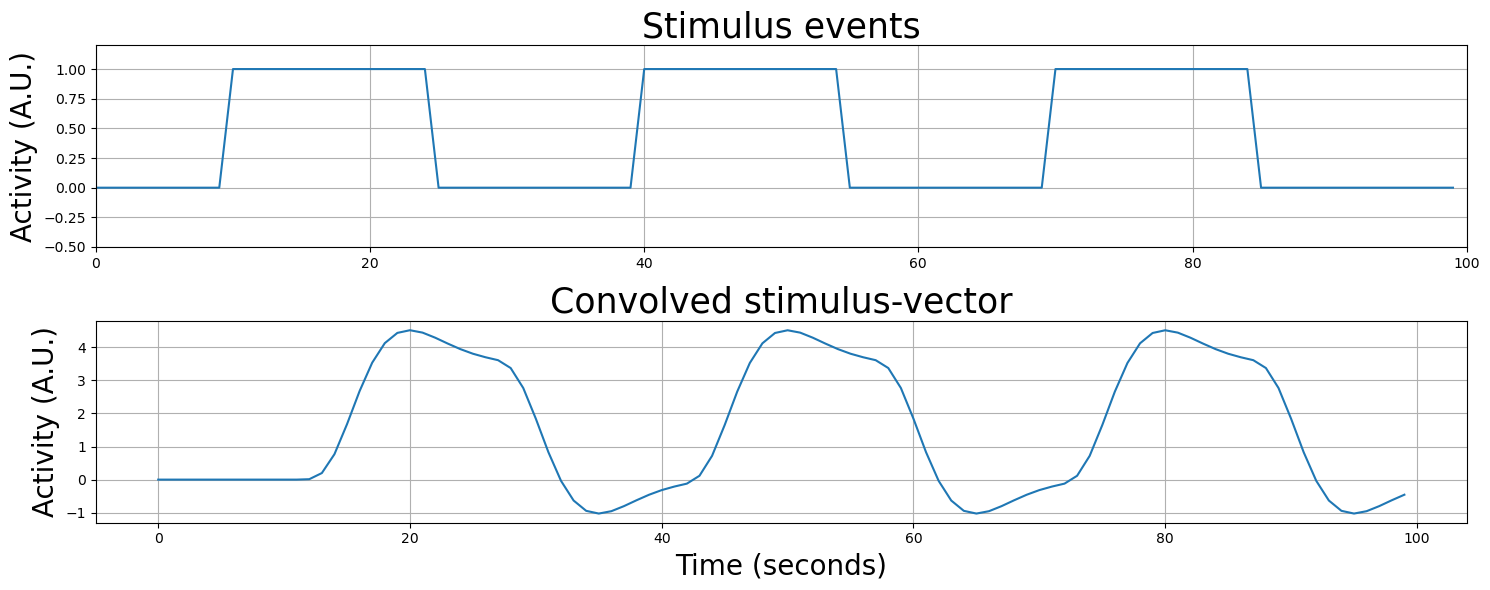

In [26]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, canonical_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

As you can see, convolution takes care to model the shape of the BOLD-response according to how long you specify the stimulus to take! 

<div class='alert alert-info'>
<b>ToThink2</b>: Given the properties of the BOLD-response (and assuming linear-time invariance is not violated), would you expect the same or a different BOLD-response in response to 3 consecutive stimuli (of the same condition) of half a second second each (which follow each other immediately, i.e. without interstimulus interval) versus 1 stimulus of 1.5 seconds? Why? (Write your answer in the text-cell below.)
</div>

Write you solution to <b>ToThink2</b> here (solutions at the end of the notebook):

#### Convolutions galore

Actually, convolution can model *any* sequence of stimulus events, even stimuli with random onsets - just look at the plot below!

(you can execute this cell below multiple times to see different random regressor shapes!)

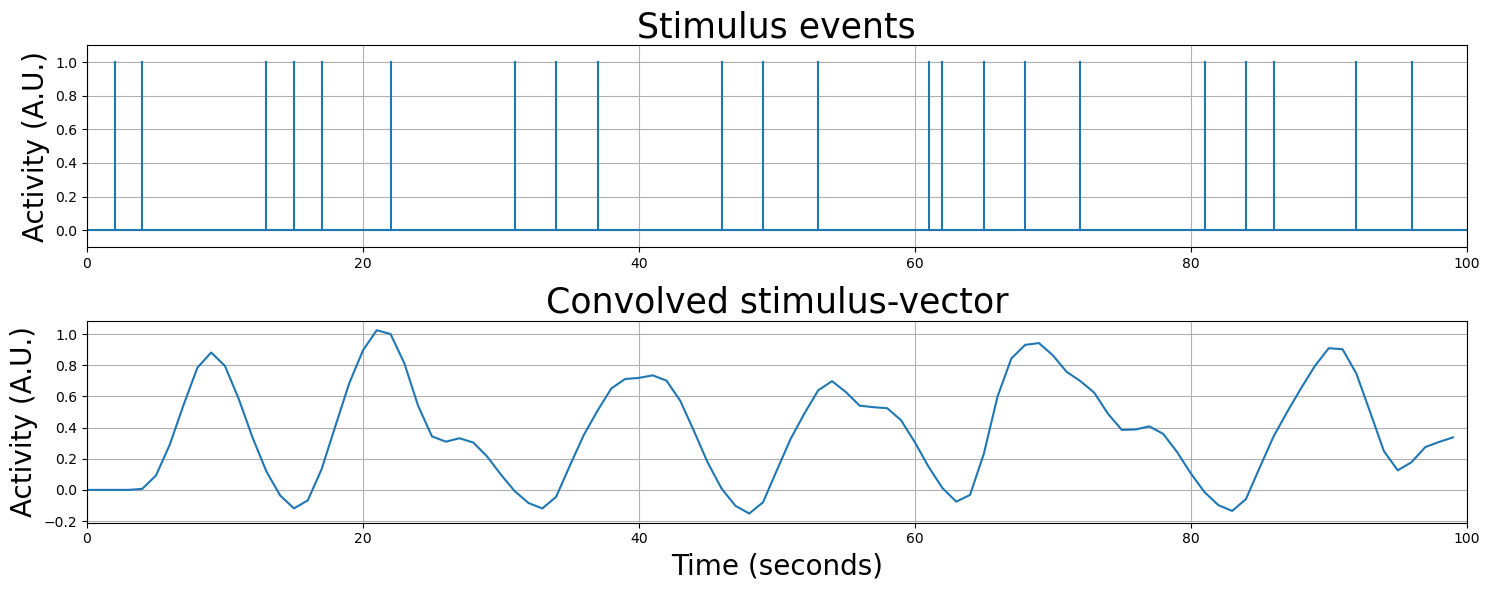

In [27]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), '-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.title('Stimulus events', fontsize=25)
plt.grid()

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, canonical_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

So, in summary</b>, convolving the stimulus-onsets (and their duration) with the HRF gives us (probably) a better predictor of the voxel signal than just the stimulus-onset, because (1) it models the lag of the BOLD-response and (2) models the shape of the BOLD-response (accounting for the linear scaling principle). 

#### Resampling revisited
Now, we're *almost* ready to start analyzing our signal with the convolved predictor! The problem, at this moment, however is that the convolved predictor and the signal are on different scales!

In [28]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % voxel_signal.size)

Size convolved predictor: 800
Size voxel signal: 400


Let's resample the convolved stimulus vector to the same scale as the voxel signal (just as we did previously), and plot the our new convolved predictor. 

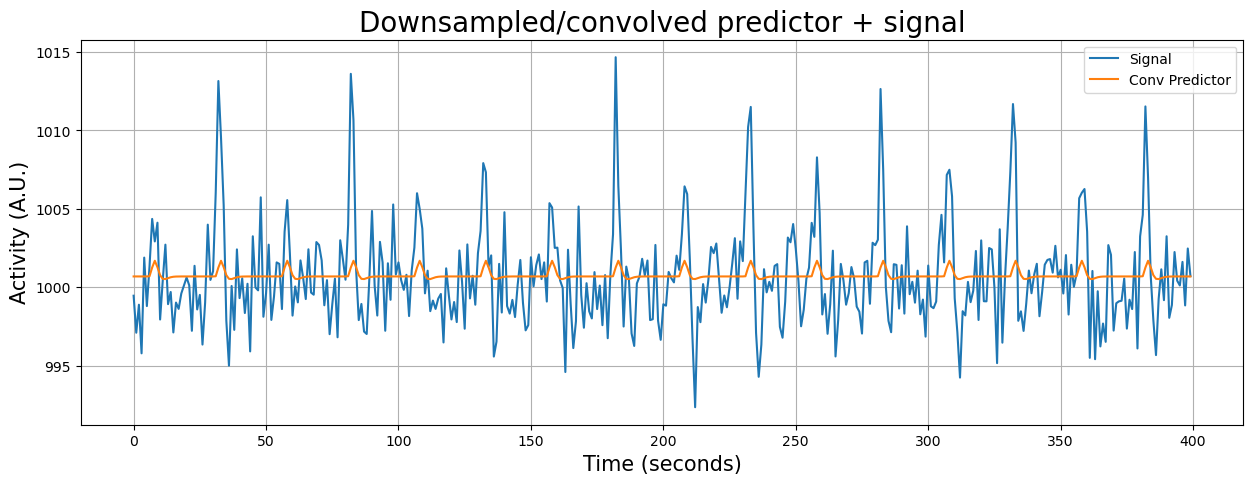

In [29]:
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(voxel_signal)
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend([ 'Signal','Conv Predictor'])
plt.show()

#### Fitting our model with the HRF-informed predictor 

Finally ... we're ready to see whether the HRF-based predictor *actually* models our original voxel signal (`voxel_signal`, from earlier in the tutorial) more accurately! Again, we'll create a design matrix, `X_conv`, this time using our convolved predictor (and still the intercept!)

<AxesSubplot: label='conditions', ylabel='scan number'>

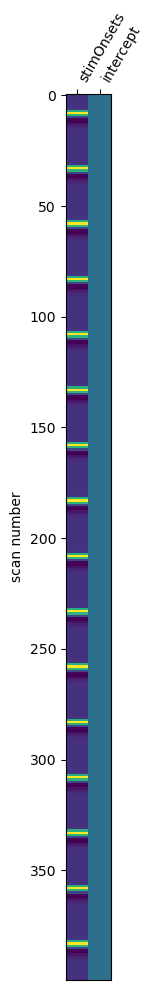

In [30]:
intercept = np.ones(len(predictor_conv_ds))

X_conv = pd.DataFrame({
    'stimOnsets': predictor_conv_ds, 
    'intercept': intercept}
)

#Plot the design matrix 
plotting.plot_design_matrix(X_conv)

And let's fit the model! 

In [31]:
#Define and fit the model 
model_conv = LinearRegression()
model_conv.fit(X_conv, voxel_signal)

#Inspect model fit (R^2 = explained varaince)
r_sq = model_conv.score(X_conv, voxel_signal)
print(f"Explained variance: {r_sq}")

#Inspect estimated beta-parameters 
print(f"Intercept: {model_conv.intercept_}")
print(f"Slope: {model_conv.coef_[0]}")

#Get predicted voxel signal given the estimated beta-parameters 
y_pred_conv = model_conv.predict(X_conv)

Explained variance: 0.4191895803897021
Intercept: 1000.1174005189549
Slope: 8.181270178495419


The beta-parameter of our predictor is now 8.18 which is three times larger than the beta of our original unconvolved predictor! 
Also, R^2 is now 0.4! Look's like this model is doing a lot better. Let's plot the true and predicted signal for the two models, for comparison: 

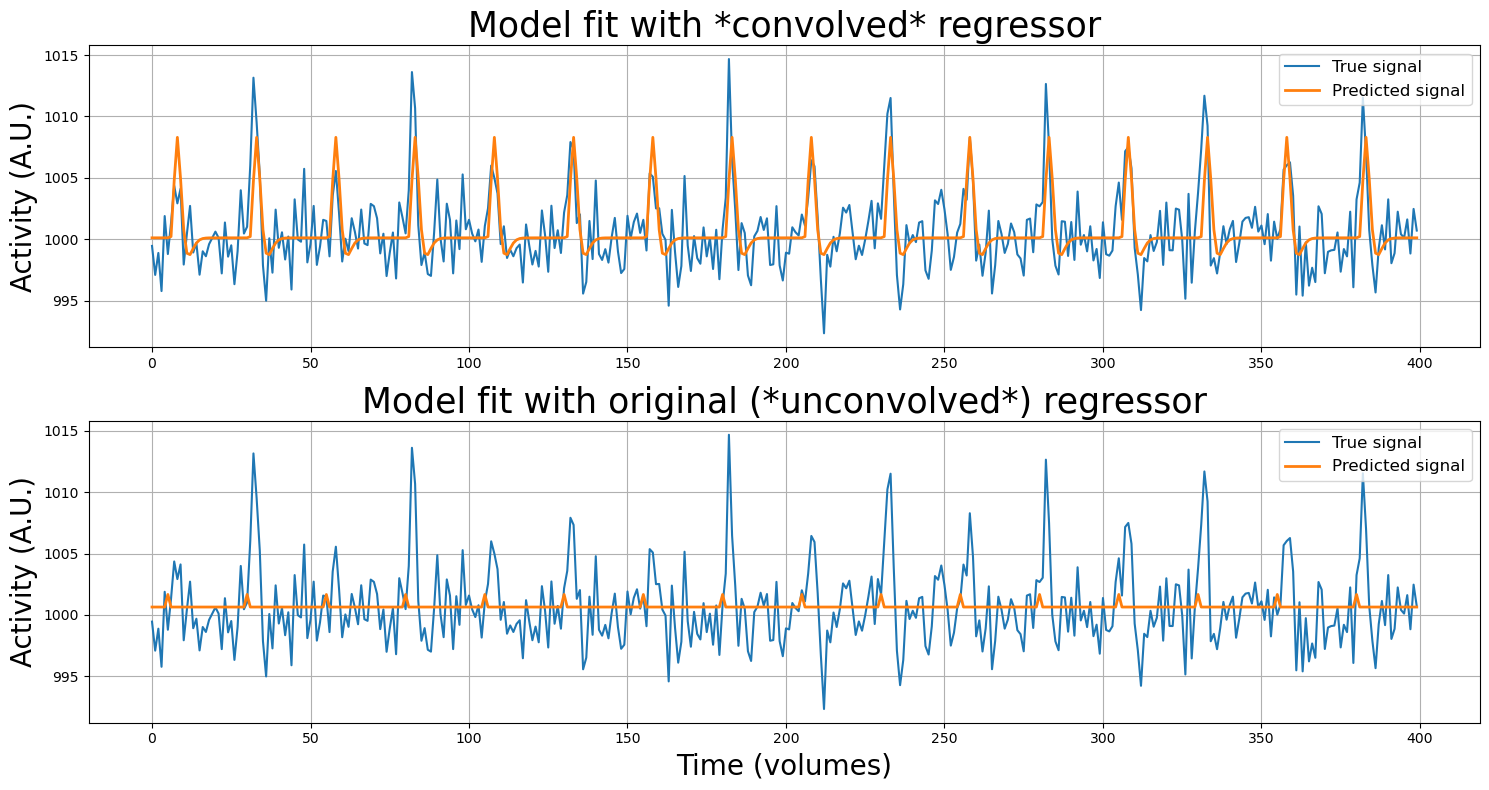

In [32]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(y_pred_conv, lw=2)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
plt.plot(y_pred, lw=2)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

From the model fit metrics above, we can safely conclude that (at least for this voxel), a design ($X$) in which we include information about the expected lag/shape of the HRF is *way* better than a 'HRF-naive' design (i.e. an unconvolved design). 

### Conclusion and next up 

Alright. Now we understand how the GLM is used with fMRI data (on the single-subject single-voxel level), and why it is important to account for the shape of the BOLD response with an HRF. 

To investigate whether the experimental conditions is systematically associated with changes in BOLD response, we estimate beta-parameters for all voxels across all subjects. This process is divided in two kinds of models: 
- First-level models (fitting a GLM to each voxel across timepoints for each subject)
    - The result is a statistical map for each subject; a 3D image with a beta-parameter of our predictor for each voxel. 
- Second-level models (estimating the effects across all subjects)
    - In second-level models the beta-parameters for each voxel obtained in first-level models are now our target (what we try to predict) 
    - The result is a statistical parametric map with beta-parameters for each voxel across all subjects 
- Then we can test statistically, whether the beta-parameter for each voxel is significantly different from 0 across the full sample (or if the difference in beta-parameters between specified groups of subjects is significantly different from 0). 

An overview of this process is visualized below. Don't worry too much about understanding this completely now. We will learn later how to estimate first-level and second-level models. 

However, in this tutorial we have worked with a very clean simulated signal. But as you have heard, fMRI data is very noisy and we need several preprocessing steps to increase our chances of modeling actual neuronal signal fluctuations rather than noise. This is the topic of the next two tutorials. 

![summary_statistics_approach.png](images/summary_statistics_approach.png)


## SOLUTIONS

<div class='alert alert-info'>
<b>Solution for ToThink1</b> :
</div>

400 measurements x 2 s (TR)= 800 s

<div class='alert alert-info'>
<b>Solution to ToThink2</b>:
</div>

Solution to ToThink2: Because the BOLD-response is so slow, it cannot distinguish between short consecutive stimuli and one longer stimulus (which is evident by the fact that after convolution of these two hypothetical stimulus-vectors, they look identical).